In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import torch.optim as optim
import fcn_train
import tqdm
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
plt.rcParams['figure.figsize'] = [15, 7.5]

In [7]:
class ResNet_FPN_FCN(nn.Module):
    def __init__(self, resnet_fpn):
        super(ResNet_FPN_FCN, self).__init__()
        
        setattr(self, 'fpn', resnet_fpn)
        
#         self.fmap_0_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_1_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_2_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_3_score = nn.Sequential(nn.Conv2d(256, 21, 1))      
    
    def forward(self, x):
        
        fpn_out = self.fpn(x)
        
#         fmap_0 = fpn_out[0]
        fmap_1 = fpn_out[1]
        fmap_2 = fpn_out[2]
        fmap_3 = fpn_out[3]
        
#         score_0 = self.fmap_0_score(fmap_0)
        score_1 = self.fmap_1_score(fmap_1)
        score_2 = self.fmap_2_score(fmap_2)
        score_3 = self.fmap_3_score(fmap_3)
        
        self.upsample_3 = nn.UpsamplingBilinear2d(size=(fmap_2.shape[2], fmap_2.shape[3]))
        self.upsample_2 = nn.UpsamplingBilinear2d(size=(fmap_1.shape[2], fmap_1.shape[3]))
#         self.upsample_1 = nn.UpsamplingBilinear2d(size=(fmap_0.shape[2], fmap_0.shape[3]))
        self.upsample_0 = nn.UpsamplingBilinear2d(size=(x.shape[2], x.shape[3]))

        score_3_upsample = self.upsample_3(score_3)
        score_2_sum = score_2 + score_3_upsample
        score_2_upsample = self.upsample_2(score_2_sum)
        score_1_sum = score_1 + score_2_upsample
#         score_1_upsample = self.upsample_1(score_1_sum)
#         upsample_0 = score_0 + score_1_upsample
        out = self.upsample_0(score_1_sum)
        
        return out

In [5]:
resnet_fpn = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
resnet_fpn.cuda()
resnet_fpn.eval()

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [5]:
img_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.Resize(800),
    transforms.ToTensor(),
    ])

In [6]:
def label_transform(label):
#     label = transforms.Resize(800)(label)
    label = np.array(label, dtype=np.int32)
    label[label == 255] = -1
    
    return torch.from_numpy(label).long()

In [7]:
seg_model = ResNet_FPN_FCN(resnet_fpn)

for name, parameter in seg_model.fpn.named_parameters():
    if 'inner_blocks' in name or 'layer_blocks' in name:
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

seg_model.cuda()
seg_model.eval()

ResNet_FPN_FCN(
  (fpn): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
        (1): Bottleneck(
          (conv1): C

In [8]:
for name, param in seg_model.named_parameters():
    if param.requires_grad:
        print(name)

fpn.fpn.inner_blocks.0.weight
fpn.fpn.inner_blocks.0.bias
fpn.fpn.inner_blocks.1.weight
fpn.fpn.inner_blocks.1.bias
fpn.fpn.inner_blocks.2.weight
fpn.fpn.inner_blocks.2.bias
fpn.fpn.inner_blocks.3.weight
fpn.fpn.inner_blocks.3.bias
fpn.fpn.layer_blocks.0.weight
fpn.fpn.layer_blocks.0.bias
fpn.fpn.layer_blocks.1.weight
fpn.fpn.layer_blocks.1.bias
fpn.fpn.layer_blocks.2.weight
fpn.fpn.layer_blocks.2.bias
fpn.fpn.layer_blocks.3.weight
fpn.fpn.layer_blocks.3.bias
fmap_1_score.0.weight
fmap_1_score.0.bias
fmap_2_score.0.weight
fmap_2_score.0.bias
fmap_3_score.0.weight
fmap_3_score.0.bias


In [9]:
train_set  = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                                download=False,
                                                year='2012',
                                                image_set='train',
                                                transform=img_transform,
                                                target_transform = label_transform)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset =train_set, batch_size=1,
                                          shuffle=True, num_workers=0)

In [11]:
x,y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([1, 3, 375, 500])
torch.Size([1, 375, 500])


In [12]:
val_set = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                              download=False,
                                              year='2012',
                                              image_set='val',
                                              transform=img_transform,
                                              target_transform = label_transform)

In [13]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                          shuffle=False, num_workers=0)

In [14]:
opt = optim.SGD(seg_model.parameters(), lr=5e-4, momentum=0.9, weight_decay = 0.0005)

In [15]:
trainer = fcn_train.Trainer(cuda = True,
                           model = seg_model,
                           optimizer = opt,
                           train_loader = train_loader,
                           val_loader = val_loader,
                           out = './seg_training',
                           max_iter = 100000,
                           interval_validate=None)

In [16]:
trainer.train()

Train:   0%|                                             | 0/69 [00:00<?, ?it/s]


Iter = 0, valid_loss = 3.063552, mean_iu, = 0.007533, acc = 0.038185



Train:   1%|4                                 | 1/69 [02:27<2:47:03, 147.40s/it]


Iter = 1464, valid_loss = 0.568565, mean_iu, = 0.364480, acc = 0.455677



Train:   3%|9                                 | 2/69 [04:55<2:44:46, 147.56s/it]


Iter = 2928, valid_loss = 0.538173, mean_iu, = 0.411802, acc = 0.524275



Train:   4%|#4                                | 3/69 [07:25<2:43:16, 148.43s/it]


Iter = 4392, valid_loss = 0.542399, mean_iu, = 0.374928, acc = 0.424173



Train:   6%|#9                                | 4/69 [09:51<2:40:02, 147.73s/it]


Iter = 5856, valid_loss = 0.532043, mean_iu, = 0.399886, acc = 0.460292



Train:   7%|##4                               | 5/69 [12:17<2:36:50, 147.04s/it]


Iter = 7320, valid_loss = 0.501866, mean_iu, = 0.442342, acc = 0.552535



Train:   9%|##9                               | 6/69 [14:47<2:35:24, 148.01s/it]


Iter = 8784, valid_loss = 0.566171, mean_iu, = 0.360755, acc = 0.403051



Train:  10%|###4                              | 7/69 [17:18<2:33:52, 148.91s/it]


Iter = 10248, valid_loss = 0.484858, mean_iu, = 0.457848, acc = 0.573076



Train:  12%|###9                              | 8/69 [19:57<2:34:30, 151.98s/it]


Iter = 11712, valid_loss = 0.483442, mean_iu, = 0.454020, acc = 0.564305



Train:  13%|####4                             | 9/69 [22:59<2:40:47, 160.79s/it]


Iter = 13176, valid_loss = 0.478930, mean_iu, = 0.458385, acc = 0.547213



Train:  14%|####7                            | 10/69 [25:45<2:39:45, 162.46s/it]


Iter = 14640, valid_loss = 0.483027, mean_iu, = 0.454289, acc = 0.553685



Train:  16%|#####2                           | 11/69 [28:11<2:32:15, 157.51s/it]


Iter = 16104, valid_loss = 0.480962, mean_iu, = 0.463416, acc = 0.617615



Train:  17%|#####7                           | 12/69 [30:51<2:30:15, 158.17s/it]


Iter = 17568, valid_loss = 0.458866, mean_iu, = 0.470428, acc = 0.571616



Train:  19%|######2                          | 13/69 [33:30<2:27:59, 158.56s/it]


Iter = 19032, valid_loss = 0.462657, mean_iu, = 0.472046, acc = 0.575987



Train:  20%|######6                          | 14/69 [35:55<2:21:29, 154.35s/it]


Iter = 20496, valid_loss = 0.472555, mean_iu, = 0.468201, acc = 0.568295



Train:  22%|#######1                         | 15/69 [38:21<2:16:49, 152.02s/it]


Iter = 21960, valid_loss = 0.455334, mean_iu, = 0.476214, acc = 0.585397



Train:  23%|#######6                         | 16/69 [40:48<2:12:51, 150.41s/it]


Iter = 23424, valid_loss = 0.470944, mean_iu, = 0.456135, acc = 0.534459



Train:  25%|########1                        | 17/69 [43:11<2:08:32, 148.31s/it]


Iter = 24888, valid_loss = 0.487541, mean_iu, = 0.447309, acc = 0.526217



Train:  26%|########6                        | 18/69 [45:35<2:04:54, 146.94s/it]


Iter = 26352, valid_loss = 0.448627, mean_iu, = 0.486953, acc = 0.598398



Train:  28%|#########                        | 19/69 [48:02<2:02:31, 147.02s/it]


Iter = 27816, valid_loss = 0.539397, mean_iu, = 0.475529, acc = 0.640285



Train:  29%|#########5                       | 20/69 [50:28<1:59:48, 146.70s/it]


Iter = 29280, valid_loss = 0.477984, mean_iu, = 0.475058, acc = 0.631177



Train:  30%|##########                       | 21/69 [52:55<1:57:19, 146.65s/it]


Iter = 30744, valid_loss = 0.478291, mean_iu, = 0.477658, acc = 0.629621



Train:  32%|##########5                      | 22/69 [55:24<1:55:28, 147.42s/it]


Iter = 32208, valid_loss = 0.467999, mean_iu, = 0.473324, acc = 0.565656



Train:  33%|###########                      | 23/69 [57:49<1:52:28, 146.71s/it]


Iter = 33672, valid_loss = 0.464687, mean_iu, = 0.483953, acc = 0.610114



Train:  35%|##########7                    | 24/69 [1:00:14<1:49:39, 146.21s/it]


Iter = 35136, valid_loss = 0.455824, mean_iu, = 0.492702, acc = 0.626014



Train:  36%|###########2                   | 25/69 [1:02:42<1:47:30, 146.60s/it]


Iter = 36600, valid_loss = 0.457074, mean_iu, = 0.493985, acc = 0.612061



Train:  38%|###########6                   | 26/69 [1:05:09<1:45:12, 146.81s/it]


Iter = 38064, valid_loss = 0.440576, mean_iu, = 0.496203, acc = 0.599846



Train:  39%|############1                  | 27/69 [1:07:39<1:43:26, 147.76s/it]


Iter = 39528, valid_loss = 0.449953, mean_iu, = 0.490219, acc = 0.579670



Train:  41%|############5                  | 28/69 [1:10:05<1:40:33, 147.15s/it]


Iter = 40992, valid_loss = 0.449569, mean_iu, = 0.490728, acc = 0.593086



Train:  42%|#############                  | 29/69 [1:12:30<1:37:47, 146.70s/it]


Iter = 42456, valid_loss = 0.455597, mean_iu, = 0.487177, acc = 0.575236



Train:  43%|#############4                 | 30/69 [1:14:55<1:35:03, 146.23s/it]


Iter = 43920, valid_loss = 0.450446, mean_iu, = 0.494097, acc = 0.613456



Train:  45%|#############9                 | 31/69 [1:17:28<1:33:48, 148.11s/it]


Iter = 45384, valid_loss = 0.450705, mean_iu, = 0.500971, acc = 0.630226



Train:  46%|##############3                | 32/69 [1:19:56<1:31:20, 148.11s/it]


Iter = 46848, valid_loss = 0.443573, mean_iu, = 0.500944, acc = 0.618493



Train:  48%|##############8                | 33/69 [1:22:25<1:28:57, 148.28s/it]


Iter = 48312, valid_loss = 0.449270, mean_iu, = 0.494706, acc = 0.598157



Train:  49%|###############2               | 34/69 [1:24:51<1:26:09, 147.71s/it]


Iter = 49776, valid_loss = 0.446241, mean_iu, = 0.498854, acc = 0.613365



Train:  51%|###############7               | 35/69 [1:27:15<1:23:00, 146.47s/it]


Iter = 51240, valid_loss = 0.445769, mean_iu, = 0.500450, acc = 0.612044



Train:  52%|################1              | 36/69 [1:29:38<1:20:08, 145.70s/it]


Iter = 52704, valid_loss = 0.453030, mean_iu, = 0.496898, acc = 0.609443



Train:  54%|################6              | 37/69 [1:32:00<1:16:59, 144.36s/it]


Iter = 54168, valid_loss = 0.451458, mean_iu, = 0.495553, acc = 0.593146



Train:  55%|#################              | 38/69 [1:34:21<1:14:09, 143.53s/it]


Iter = 55632, valid_loss = 0.444887, mean_iu, = 0.500416, acc = 0.611635



Train:  57%|#################5             | 39/69 [1:36:42<1:11:22, 142.75s/it]


Iter = 57096, valid_loss = 0.444705, mean_iu, = 0.501010, acc = 0.618147



Train:  58%|#################9             | 40/69 [1:39:06<1:09:08, 143.04s/it]


Iter = 58560, valid_loss = 0.452170, mean_iu, = 0.495074, acc = 0.590969



Train:  59%|##################4            | 41/69 [1:41:27<1:06:28, 142.44s/it]


Iter = 60024, valid_loss = 0.450451, mean_iu, = 0.496855, acc = 0.603341



Train:  61%|##################8            | 42/69 [1:43:48<1:03:56, 142.08s/it]


Iter = 61488, valid_loss = 0.446357, mean_iu, = 0.500268, acc = 0.612749



Train:  62%|###################3           | 43/69 [1:46:09<1:01:25, 141.74s/it]


Iter = 62952, valid_loss = 0.446262, mean_iu, = 0.499283, acc = 0.608912



Train:  64%|#####################            | 44/69 [1:48:30<58:58, 141.53s/it]


Iter = 64416, valid_loss = 0.452034, mean_iu, = 0.496310, acc = 0.597681



Train:  65%|#####################5           | 45/69 [1:50:52<56:38, 141.62s/it]


Iter = 65880, valid_loss = 0.449297, mean_iu, = 0.497504, acc = 0.599201



Train:  67%|######################           | 46/69 [1:53:13<54:12, 141.43s/it]


Iter = 67344, valid_loss = 0.448800, mean_iu, = 0.497815, acc = 0.601043



Train:  68%|######################4          | 47/69 [1:55:34<51:49, 141.32s/it]


Iter = 68808, valid_loss = 0.448818, mean_iu, = 0.499150, acc = 0.606108



Train:  70%|######################9          | 48/69 [1:57:56<49:28, 141.34s/it]


Iter = 70272, valid_loss = 0.449641, mean_iu, = 0.497502, acc = 0.600070



Train:  71%|#######################4         | 49/69 [2:00:17<47:06, 141.32s/it]


Iter = 71736, valid_loss = 0.449100, mean_iu, = 0.498757, acc = 0.604534



Train:  72%|#######################9         | 50/69 [2:02:38<44:42, 141.17s/it]


Iter = 73200, valid_loss = 0.450179, mean_iu, = 0.497978, acc = 0.601932



Train:  74%|########################3        | 51/69 [2:04:59<42:19, 141.11s/it]


Iter = 74664, valid_loss = 0.451197, mean_iu, = 0.496814, acc = 0.596603



Train:  75%|########################8        | 52/69 [2:07:20<40:00, 141.19s/it]


Iter = 76128, valid_loss = 0.450130, mean_iu, = 0.497405, acc = 0.598795



Train:  77%|#########################3       | 53/69 [2:09:41<37:37, 141.09s/it]


Iter = 77592, valid_loss = 0.449795, mean_iu, = 0.497742, acc = 0.599816



Train:  78%|#########################8       | 54/69 [2:12:04<35:25, 141.72s/it]


Iter = 79056, valid_loss = 0.449793, mean_iu, = 0.497792, acc = 0.600367



Train:  80%|##########################3      | 55/69 [2:14:25<33:02, 141.61s/it]


Iter = 80520, valid_loss = 0.449819, mean_iu, = 0.498429, acc = 0.603588



Train:  81%|##########################7      | 56/69 [2:16:47<30:39, 141.49s/it]


Iter = 81984, valid_loss = 0.451568, mean_iu, = 0.496626, acc = 0.596271



Train:  83%|###########################2     | 57/69 [2:19:08<28:16, 141.34s/it]


Iter = 83448, valid_loss = 0.450056, mean_iu, = 0.497829, acc = 0.600715



Train:  84%|###########################7     | 58/69 [2:21:29<25:54, 141.29s/it]


Iter = 84912, valid_loss = 0.450303, mean_iu, = 0.497576, acc = 0.599800



Train:  86%|############################2    | 59/69 [2:23:50<23:33, 141.31s/it]


Iter = 86376, valid_loss = 0.450736, mean_iu, = 0.497229, acc = 0.598367



Train:  87%|############################6    | 60/69 [2:26:11<21:10, 141.20s/it]


Iter = 87840, valid_loss = 0.450370, mean_iu, = 0.497576, acc = 0.599932



Train:  88%|#############################1   | 61/69 [2:28:32<18:49, 141.15s/it]


Iter = 89304, valid_loss = 0.450201, mean_iu, = 0.497704, acc = 0.600444



Train:  90%|#############################6   | 62/69 [2:30:53<16:28, 141.25s/it]


Iter = 90768, valid_loss = 0.449944, mean_iu, = 0.497986, acc = 0.601727



Train:  91%|##############################1  | 63/69 [2:33:14<14:07, 141.17s/it]


Iter = 92232, valid_loss = 0.450274, mean_iu, = 0.497679, acc = 0.600379



Train:  93%|##############################6  | 64/69 [2:35:36<11:45, 141.15s/it]


Iter = 93696, valid_loss = 0.450160, mean_iu, = 0.497824, acc = 0.601067



Train:  94%|###############################  | 65/69 [2:37:57<09:24, 141.17s/it]


Iter = 95160, valid_loss = 0.450280, mean_iu, = 0.497754, acc = 0.600792



Train:  96%|###############################5 | 66/69 [2:40:18<07:03, 141.20s/it]


Iter = 96624, valid_loss = 0.450191, mean_iu, = 0.497817, acc = 0.600995



Train:  97%|################################ | 67/69 [2:42:39<04:42, 141.16s/it]


Iter = 98088, valid_loss = 0.450178, mean_iu, = 0.497834, acc = 0.601101



Train:  99%|################################5| 68/69 [2:45:00<02:21, 141.19s/it]


Iter = 99552, valid_loss = 0.450256, mean_iu, = 0.497772, acc = 0.600808



In [9]:
best_model = ResNet_FPN_FCN(resnet_fpn)
best_model_path =  './seg_training/best_models/ResNet_FPN_FCN_best_2.pth.tar'
best_model_ckpt = torch.load(best_model_path)
best_model.load_state_dict(best_model_ckpt['model_state_dict'])
best_model.cuda()
best_model.eval()

ResNet_FPN_FCN(
  (fpn): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
        (1): Bottleneck(
          (conv1): C

Text(0.5, 1.0, 'Resnet FPN features+FCN')

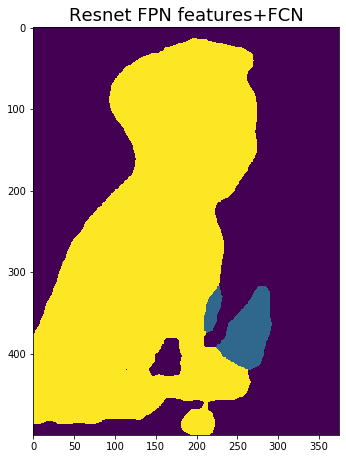

In [13]:
input = Image.open('../datasets/VOCdevkit/VOC2012/JPEGImages/2007_000999.jpg')
transform = transforms.Compose(
    [   transforms.ToTensor(),
#       transforms.Normalize(
#       mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
input = transform(input)
input = torch.unsqueeze(input, dim=0)
input = input.cuda()
seg_out = best_model(input)
seg_out.cpu()
_, y_argmax = torch.max(seg_out, dim=1)
y_argmax = y_argmax.cpu()
seg_map = y_argmax.detach().numpy()
seg_map = np.squeeze(seg_map)
plt.imshow(seg_map)
plt.title('Resnet FPN features+FCN', size=18)